In [1]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
from PIL import Image, ImageOps
import torch
import pdb
import numpy as np
import yaml
from tqdm import tqdm

In [2]:
# Define the subjects for each split
train_subjects = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 3, 5, 6, 7, 10,25, 1, 2, 8]
val_subjects = [24,  4]
test_subjects = [22, 9]

# Define the background variations
background_variations = ['d1']#'d2', 'd3', 'd4'

processed_folder = './processed/'

In [3]:
#load config file and hyperparams
config = yaml.safe_load(open("config.yaml"))
LR = float(config["LR"])
batch_size = int(config["BATCH_SIZE"])
num_epochs = int(config["NUM_EPOCHS"])


In [10]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    # Add more augmentations if needed
])

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
class SequencesExtractor:
    def __init__(self, path, num_frames_per_subsequence=20, l2_loss_threshold=100000):
        # Define the number of frames per subsequence
        self.num_frames_per_subsequence = num_frames_per_subsequence
        # List all action folders in the processed folder
        # self.classes = os.listdir(path) # folders correspond to classes/labels
        self.classes = ["boxing", "handclapping", "handwaving"]
        self.class_to_label = {class_name: idx for idx, class_name in enumerate(self.classes)}
        self.id_to_class = {idx: class_name for class_name, idx in self.class_to_label.items()}
        self.l2_loss_threshold = l2_loss_threshold
    
    def get_classes(self):
        return self.classes
    
    def get_encoding_dicts(self):
        return self.class_to_label, self.id_to_class
    
    def _filter_dot_files(self, image_files):
        # Filter out files that start with a dot
        filtered_files = [file for file in image_files if not (file.startswith('.') or not file.startswith('image'))]

        return filtered_files
    
    def _l2cost(self, img1, img2):
        return np.sum((img1 - img2) ** 2)
    
    def _calculate_total_l2loss(self, imgs):
        
        sum_l2s = 0
        for i in range(1, len(imgs)):
            sum_l2s+=np.sum((imgs[i] - imgs[i-1]) ** 2)
        return sum_l2s
    
    def create_sequences(self, subjects, background_variations):
        sequences = []
        target_arr = []
        # Iterate over each action folder
        for action_folder in self.classes:
            target = action_folder
            action_path = os.path.join(processed_folder, action_folder)

            # List all person folders in the action folder
            person_folders_actual = os.listdir(action_path)
            # Filter videos based on subjects and background variations
            person_folders_target = [f'person{subject:02d}_{action_folder}_{bg}' 
                           for subject in subjects 
                           for bg in background_variations]
            person_folders = set(person_folders_actual) & set(person_folders_target) # it can be that some background variations (or smth else) is missing. 
            # Iterate over each person folder
            for person_folder in person_folders:
                person_path = os.path.join(action_path, person_folder)
                # List all image files in the person folder
                image_files = sorted(os.listdir(person_path))
                #filter out files with a dot or something else than img at the start
                image_files = self._filter_dot_files(image_files)
                # Split the image files into subsequences
                num_frames = len(image_files)
                num_subsequences = num_frames // self.num_frames_per_subsequence
                
                for i in range(num_subsequences):
                    start_index = i * self.num_frames_per_subsequence
                    end_index = start_index + self.num_frames_per_subsequence
                    
                    imgs = []
                    # Load and process the frames in the subsequence
                    subsequence_frames = []
                    for j in range(start_index, end_index):
                        # try:
                        image_path = os.path.join(person_path, image_files[j])
                        frame = Image.open(image_path).convert('RGB')
                        imgs.append(np.array(ImageOps.grayscale(frame)))
                        # Apply any desired spatial augmentations to the frame
                        frame = transform(frame)
                        subsequence_frames.append(frame)

                        # except:
                        #     print("Tried to read wrong file. Continuing")
                        #     continue
        
                  #  subsequence_frames = torch.stack(subsequence_frames, dim=0)
                    # Perform further processing on the subsequence
                    # Check if subsequence has the expected number of frames
                    if len(subsequence_frames) == self.num_frames_per_subsequence:
                        # Process the subsequence (e.g., feed it to a model for action classification)
                        #subsequence_frames = torch.stack(subsequence_frames, dim=0)
                        # Perform further processing on the subsequence
                            # if action_folder in ['running', 'jogging', 'walking']:  
                            #     l2loss_acc = self._calculate_total_l2loss(imgs)
                            #     if l2loss_acc > self.l2_loss_threshold:
                        subsequence_frames = torch.stack(subsequence_frames, dim=0)
                        target_arr.append(self.class_to_label[target])
                        sequences.append(subsequence_frames)
                                # else:
                                #     print("Discarding sequence due to lack of overall change in the sequence's imgs")
                                #     print(f"Class : {action_folder}")
                        # else: 
                        #     subsequence_frames = torch.stack(subsequence_frames, dim=0)
                        #     target_arr.append(self.class_to_label[target])
                        #     sequences.append(subsequence_frames)
                                
                    else:
                        print(f"Skipping subsequence due to incorrect number of frames: {len(subsequence_frames)}")
                        # target_arr.append(self.class_to_label[target])
                        # sequences.append(subsequence_frames)
        return np.array(sequences, dtype = np.float64), np.array(target_arr)

In [13]:
sequencesExtractor = SequencesExtractor(path=processed_folder, num_frames_per_subsequence=20)
train_sequences, train_target_arr = sequencesExtractor.create_sequences(train_subjects, background_variations)
test_sequences, test_target_arr = sequencesExtractor.create_sequences(test_subjects, background_variations)
val_sequences, val_target_arr = sequencesExtractor.create_sequences(val_subjects, background_variations)

In [14]:
def create_dataloaders(inputs, labels, batch_size, shuffle=False):
    input_tensor = torch.tensor(inputs, dtype=torch.float32)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4)
    return dataloader

In [15]:
print(f"Training sequences length: {len(train_sequences)}")
print(f"Validation sequences length: {len(val_sequences)}")
print(f"Test sequences length: {len(test_sequences)}")

Training sequences length: 1447
Validation sequences length: 137
Test sequences length: 132


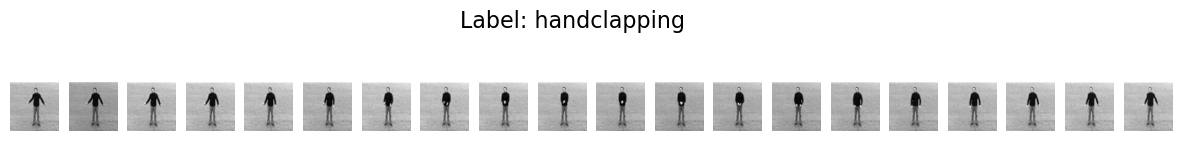

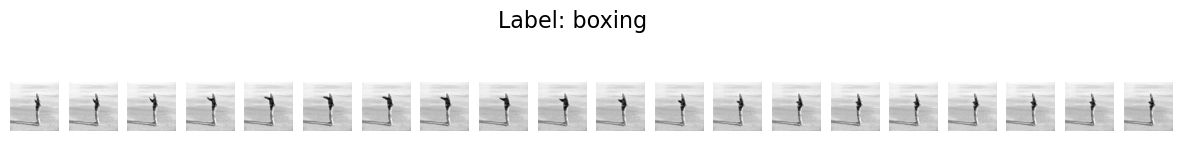

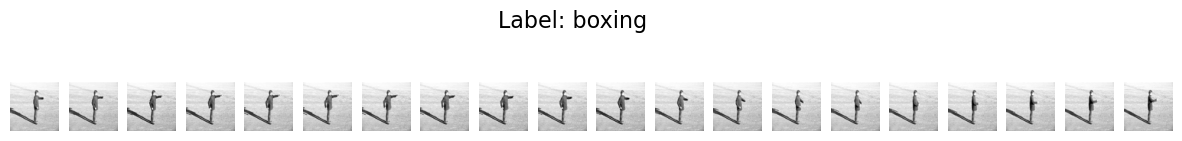

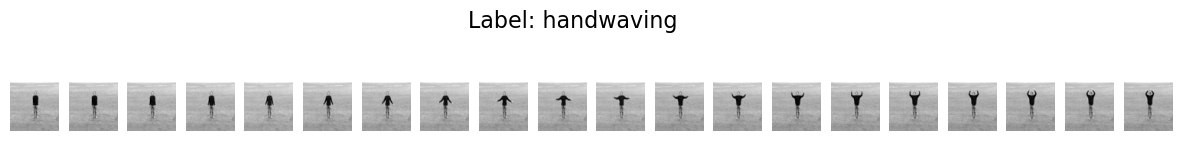

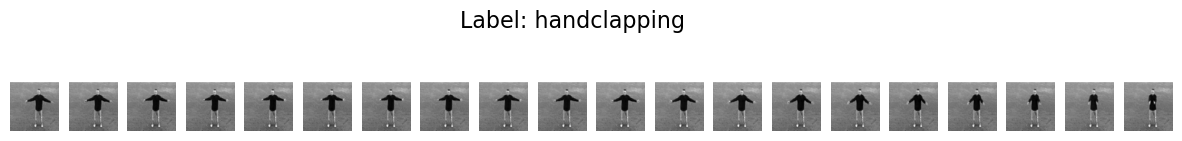

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in the variables data_array and label_array
# Replace these with your actual variable names
_, label_to_class = sequencesExtractor.get_encoding_dicts()
data_array = train_sequences # Replace this with your actual data
label_array = train_target_arr  # Replace this with your actual labels

# Choose a random index to select one sequence
random_indices = np.random.choice(len(data_array), size=5, replace=False)

for random_index in random_indices:
    # Get the random sequence and its label
    selected_sequence = data_array[random_index]
    label = label_array[random_index]

    # Visualize the sequence
    fig, axes = plt.subplots(1, selected_sequence.shape[0], figsize=(15, 2))

    # Display images in the sequence
    for i in range(selected_sequence.shape[0]):
        axes[i].imshow(selected_sequence[i, 0, :, :], cmap='gray')
        axes[i].axis('off')

    # Set the label as the title of the plot
    fig.suptitle(f"Label: {label_to_class[label]}", fontsize=16)

    # Show the plot
    plt.show()


In [17]:
from torch.utils.data import Dataset, DataLoader

In [18]:
class KTHDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]

        return sequence, label

In [19]:
# train_dataset = KTHDataset(train_sequences, train_target_arr)
# test_dataset = KTHDataset(test_sequences, test_target_arr)
# val_dataset = KTHDataset(val_sequences, val_target_arr)

In [20]:
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_dataloader = create_dataloaders(train_sequences,train_target_arr, batch_size=batch_size, shuffle=True)
val_dataloader = create_dataloaders(val_sequences,val_target_arr, batch_size=batch_size, shuffle=True)
test_dataloader = create_dataloaders(test_sequences,test_target_arr, batch_size=batch_size, shuffle=True)

In [21]:
if(not os.path.exists("models")):
    os.makedirs("models")

In [22]:
class ConvBlock(nn.Module):
    """
    Encapuslation of a convolutional block (conv + activation + pooling)
    """
    def __init__(self, in_ch, out_ch, k_size, pool=False, dropout_prob = 0.2, mxpool_stride=1):
        super(ConvBlock, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_ch, out_ch, k_size))
        layers.append(nn.ReLU())
        if(pool):
            layers.append(nn.MaxPool2d(kernel_size=2, stride = mxpool_stride))
       # layers.append(nn.Dropout(p=dropout_prob))
        self.module = nn.Sequential(*layers)
    def forward(self, x):
        return(self.module(x))


In [23]:
class ConvRecurrentClassifier(nn.Module):
    def __init__(self, input_channels, hidden_size, num_classes,num_layers = 5, mode="random", recurrent_module="lstm"):
        assert mode in ["zeros", "random"]
        super(ConvRecurrentClassifier, self).__init__()
        self.mode = mode
        self.num_layers = num_layers
        self.hidden_dim = hidden_size
        #Convolutional Encoder
        # self.conv_encoder = nn.Sequential(
        #     ConvBlock(3, 16, 3, pool=False),
        #     ConvBlock(16, 32, 3, pool=True),
        #     ConvBlock(32, 64, 3, pool=False),
        #     ConvBlock(64, 128, 3, pool=True)
        # )
        
        self.conv_encoder = nn.Sequential(
            # nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # Add more convolutional layers if needed
            ConvBlock(3, 16, 3, pool=False),
            ConvBlock(16, 32, 3, pool=True, mxpool_stride=2),
            ConvBlock(32, 64, 3, pool=False),
            ConvBlock(64, 128, 3, pool=True, mxpool_stride=2),
            ConvBlock(128, 256, 3, pool=False),
            ConvBlock(256, 512, 3, pool=True, mxpool_stride=2),
            ConvBlock(512, 1024, 3, pool=False)
        )
        
        #Recurrent Module
        if recurrent_module == "lstm":
            # LSTM model  
            lstms = []
            for i in range(num_layers):
                in_size = 4096 if i == 0 else self.hidden_dim
                lstms.append( nn.LSTMCell(input_size=in_size, hidden_size=self.hidden_dim) )
            self.lstm = nn.ModuleList(lstms)
            self.recurrent_module = self._LSTMforward
        elif recurrent_module == "gru":
            grus = []
            for i in range(num_layers):
                in_size = 4096 if i == 0 else self.hidden_dim
                grus.append(nn.GRUCell(input_size=in_size, hidden_size=self.hidden_dim))
            self.gru = nn.ModuleList(grus)
            self.recurrent_module = self._GRUforward
            
        
        
        #Recurrent Module
        # self.lstm = nn.LSTM(input_size=4096, hidden_size=hidden_size, batch_first=True)
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
        )
    def _LSTMforward(self, embeddings, b_size):
        h, c = self.lstm_init_state(b_size=b_size, device=device)
        lstm_out = []
        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:, i, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, (h[j], c[j]))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)
        # Take the output from the last time step
        out = lstm_out[:, -1, :]
        return out
    
    def _GRUforward(self, embeddings, b_size):
        h = self.gru_init_state(b_size=b_size, device=device)
        gru_out = []
        for i in range(embeddings.shape[1]):
            gru_input = embeddings[:, i, :]
            # iterating over GRU Cells
            for j, gru_cell in enumerate(self.gru):
                h[j] = gru_cell(gru_input, h[j])
                gru_input = h[j]
            gru_out.append(gru_input)
        gru_out = torch.stack(gru_out, dim=1)
        # Take the output from the last time step
        out = gru_out[:, -1, :]
        return out
    
    def forward(self, x):
        b_size, seq_length, n_channels, width, height = x.shape
        # Reshape input to (batch_size, channels, sequence_length*height, width)
        x = x.view(b_size*seq_length, n_channels, width, height)
        
       # h, c = self.init_state(b_size=b_size, device=device)
         # Convolutional Encoder
        x = self.conv_encoder(x)
        
        # Reshape for LSTM
        embeddings = x.view(b_size, seq_length, -1)
        # Recurrent Module
        out = self.recurrent_module(embeddings, b_size)
        
        
        # Classifier
        out = self.classifier(out)
        
        return out
    def lstm_init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        elif(self.mode == "random"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        return h, c
    
    def gru_init_state(self, b_size, device):
        """ Initializing hidden state """
        if(self.mode == "zeros"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        elif(self.mode == "random"):
            h = [torch.randn(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        return h

In [24]:
print(len(sequencesExtractor.get_classes()))

3


In [25]:
model = ConvRecurrentClassifier(input_channels=3, hidden_size=1024, num_classes=len(sequencesExtractor.get_classes()),recurrent_module="gru")

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001) #adamW was used in the paper
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=num_epochs)
model = model.to(device)

cuda


In [27]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

47220643


In [28]:
torch.cuda.empty_cache()

In [29]:
@torch.no_grad()
def eval_model(model):
    """ Computing model accuracy """
    correct = 0
    total = 0
    loss_list = []
    
    for sequences, labels in val_dataloader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(sequences)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss

In [30]:
#SAMPLE Training
loss_hist = []
train_acc_hist = []
valid_acc_hist = []
valid_loss_hist = []
best_loss = 100
for epoch in range(num_epochs):
    loss_list = []
    acc_list = []
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for i, (sequences, labels) in progress_bar:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(sequences)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        with torch.no_grad():
            predicted = outputs.argmax(dim=-1)
            correct = (predicted == labels).sum().item()
            accuracy = correct/labels.shape[0] * 100
        acc_list.append(accuracy)
        # Getting gradients w.r.t. parameters
        loss.backward()
       # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2.0)
        # Updating parameters
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. train accuracy: {accuracy}")
    
    loss_hist.append(np.mean(loss_list))
    train_acc_hist.append(np.mean(acc_list))
    val_accuracy, valid_loss = eval_model(model)
    if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"models/checkpoint_epoch_{epoch}.pth")
    print(f"Val accuracy at epoch {epoch}: {round(val_accuracy, 2)}%")
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(val_accuracy)

Epoch 1 Iter 12: loss 0.00113. train accuracy: 100.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.59it/s]


Val accuracy at epoch 0: 47.45%


Epoch 2 Iter 12: loss 0.00315. train accuracy: 100.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.72it/s]


Val accuracy at epoch 1: 47.45%


Epoch 3 Iter 12: loss 0.00356. train accuracy: 100.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


Val accuracy at epoch 2: 47.45%


Epoch 4 Iter 12: loss 0.00077. train accuracy: 100.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


Val accuracy at epoch 3: 47.45%


Epoch 5 Iter 12: loss 0.00000. train accuracy: 100.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


Val accuracy at epoch 4: 47.45%


Epoch 6 Iter 12: loss 0.00000. train accuracy: 100.0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.72it/s]


Val accuracy at epoch 5: 47.45%


Epoch 7 Iter 12: loss 2.84233. train accuracy: 0.0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


Val accuracy at epoch 6: 47.45%


Epoch 8 Iter 12: loss 0.18255. train accuracy: 97.43589743589743: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.66it/s]


Val accuracy at epoch 7: 47.45%


Epoch 9 Iter 12: loss 1.15788. train accuracy: 38.46153846153847: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.70it/s]


Val accuracy at epoch 8: 47.45%


Epoch 10 Iter 12: loss 0.35808. train accuracy: 84.61538461538461: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


Val accuracy at epoch 9: 47.45%


Epoch 11 Iter 12: loss 2.78981. train accuracy: 0.0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.68it/s]


Val accuracy at epoch 10: 39.42%


Epoch 12 Iter 12: loss 0.06028. train accuracy: 100.0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


Val accuracy at epoch 11: 47.45%


Epoch 13 Iter 12: loss 2.33369. train accuracy: 2.564102564102564: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


Val accuracy at epoch 12: 40.88%


Epoch 14 Iter 12: loss 0.38756. train accuracy: 94.87179487179486: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.70it/s]


Val accuracy at epoch 13: 45.99%


Epoch 15 Iter 12: loss 2.57127. train accuracy: 2.564102564102564: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.69it/s]


Val accuracy at epoch 14: 32.85%


Epoch 16 Iter 12: loss 0.52254. train accuracy: 84.61538461538461: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


Val accuracy at epoch 15: 45.26%


Epoch 17 Iter 12: loss 1.12378. train accuracy: 48.717948717948715: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.70it/s]


Val accuracy at epoch 16: 38.69%


Epoch 18 Iter 12: loss 1.22481. train accuracy: 43.58974358974359: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.69it/s]


Val accuracy at epoch 17: 35.04%


Epoch 19 Iter 12: loss 1.12313. train accuracy: 43.58974358974359: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.70it/s]


Val accuracy at epoch 18: 27.01%


Epoch 20 Iter 12: loss 1.29812. train accuracy: 33.33333333333333: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.67it/s]


Val accuracy at epoch 19: 29.2%
